In [1]:
import kdshmap as kd
import qutip as q
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import scipy as sp

In this notebook, we demonstrate how kdshmap outputs useful information for understanding decoherence in quantum systems with a few experimentally relevant examples. The examples include:

* Qubit subjected to an echo pulse sequence, CPMG
* Driven transmon coupled to a near-resonant two-level system
* Heavy fluxonium qubit at half flux quantum sweet spot addressed by fast-flux pulses

In [2]:
## plot setup

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('axes', labelsize=15) 
matplotlib.rc('axes', labelsize=15) 

plt.rcParams["font.family"] = "Computer Modern Roman"
plt.rcParams.update({
    "text.usetex": True
})

# Example: CPMG

## qutip Hamiltonian setup

In [3]:
# qubit static part

freq = 0.5  # energy splitting between qubit 0 and 1; angular frequency
sz = -q.sigmaz() # ones state has a higher energy than zero's
sx = q.sigmax()
Hq = 2 * np.pi * freq/2 * sz # converted to angular frequency and then energy

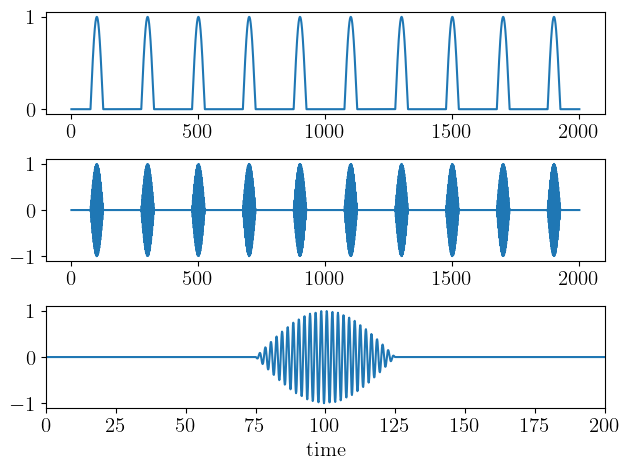

In [4]:
# pulse engineering

## single echo pulse envelope
def gaussian_env(t_list, mid, duration, scale):
    
    env = sp.stats.norm(loc = mid, scale = scale).pdf(t_list)
    env_min = np.amin(env[np.where((t_list>mid-duration/2) & (t_list<mid+duration/2))])
    env = env - env_min
    env = np.fmax(env, np.zeros(env.shape))
    env = env/np.amax(env)

    return env
    
N_CPMG = 10
t_end = 2000
t_pulse = 50
N_sample = 2**14
t_list = np.linspace(0,t_end,N_sample)

env_total = np.zeros(len(t_list))
for n_ in range(N_CPMG):
    t_center = t_end/N_CPMG * (n_ + 1/2)
    env_total += gaussian_env(t_list, t_center, t_pulse, t_pulse/2)

drive = np.sin(2*np.pi*freq * t_list)
drive *= env_total

fig, ax = plt.subplots(3,1)
ax[0].plot(t_list, env_total)
ax[1].plot(t_list, drive)
ax[2].plot(t_list, drive)
ax[2].set_xlim(0, t_end/N_CPMG)
ax[2].set_xlabel('time')
plt.tight_layout()

amp = np.pi/np.sum(env_total[np.where(t_list<t_end/N_CPMG)])/abs(t_list[1]-t_list[0]) * 1.0
drive = drive*amp

In [5]:
## Hamiltonian

drive_func = sp.interpolate.CubicSpline(t_list, drive)
H = [Hq, [sx, drive_func]]

## *kdshmap* output

### Solver initialization

In [6]:
# Noise spectrum
fp = 1/t_list[-1]
f_list = np.linspace(-fp*100, fp*100, 4000)
Af = 1e-6
Sf_list = np.fmin(Af/abs(f_list), Af/fp*10)


t_list_output = np.linspace(0, t_list[-1], 401)  ## time moments when dynamical maps will be calculated
minimal_step = 1/freq/15 ## minimal time step used to calculate propagators. 
##  should be sufficiently small to describe the fastest Hamiltonian variation

import kdshmap as kd
solver = kd.KeldyshSolver(H, t_list_output, 
                          minimal_step, 
                          noise_ops=[sz], 
                          f_list=[f_list], 
                          Sf_list=[Sf_list], 
                          trunc_freq=[(-0.04, 0.04)], 
                          spd_renorm_method = 'trapz', goal=None)


### final time filter function

<Axes: xlabel='frequency (unit of time$^{-1}$)', ylabel='filter strength'>

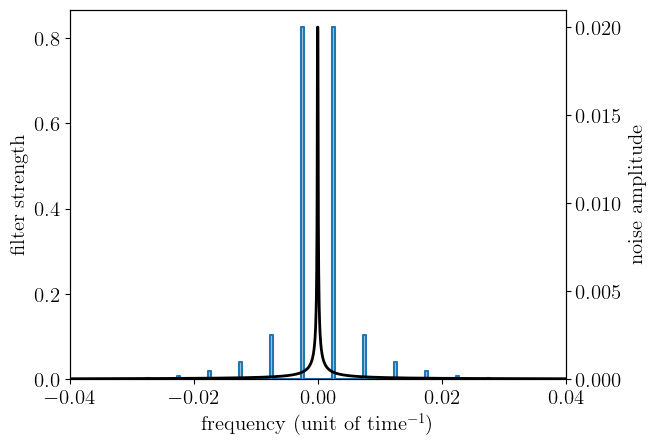

In [7]:
solver.plot_filter_Sf()

### decoherence error over time 

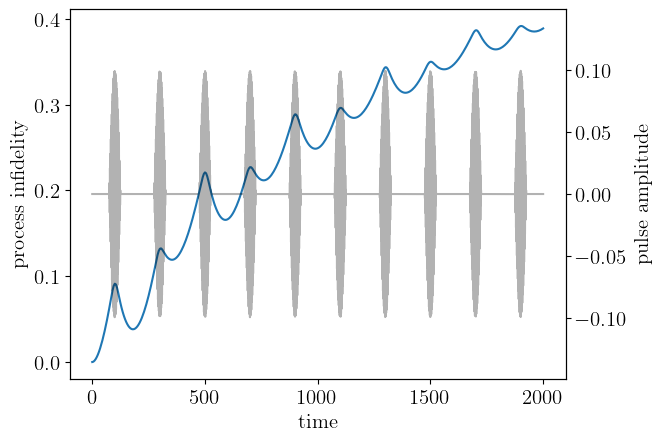

In [8]:
solver.generate_errors()
fig, ax = plt.subplots(1,1)

ax.plot(solver.t_list_sub, solver.error_list)
ax.set_xlabel('time')
ax.set_ylabel('process infidelity')
ax1 = ax.twinx()
ax1.plot(t_list, drive, 'k', alpha = 0.3)
ax1.set_ylabel('pulse amplitude')
_ = ax1.set_ylim(-np.amax(drive)*1.5, np.amax(drive)*1.5)

## expect values

Text(0.5, 1.0, 'Intial state: 1')

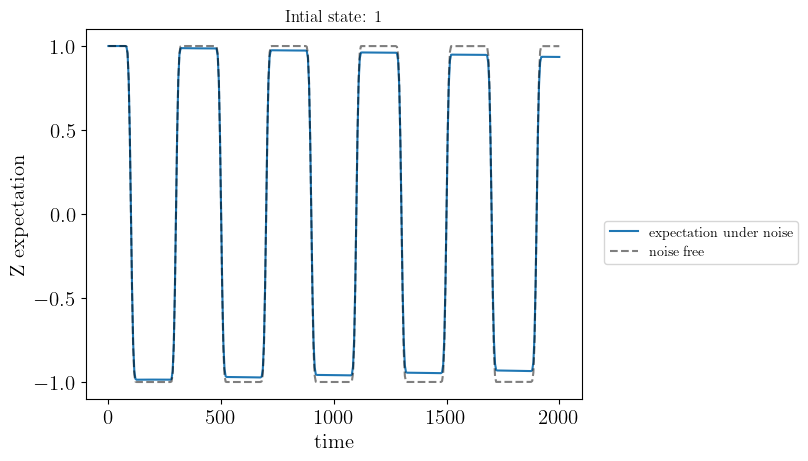

In [9]:
solver.e_ops = [sz]
pure_state = q.basis(2,1)

solver.density0 = pure_state * pure_state.dag()
expect_list, expect_noise_free_list = solver.generate_expect()
plt.plot(solver.t_list_sub, expect_list[0].real, label = 'expectation under noise')
plt.plot(solver.t_list_sub, expect_noise_free_list[0].real, 'k--', label = 'noise free', alpha = 0.5)
plt.legend(bbox_to_anchor=(0.95, 0., 0.5, 0.5))
plt.xlabel('time')
plt.ylabel('Z expectation')
plt.title('Intial state: 1')

Text(0.5, 1.0, 'Intial state: +, Ramsey')

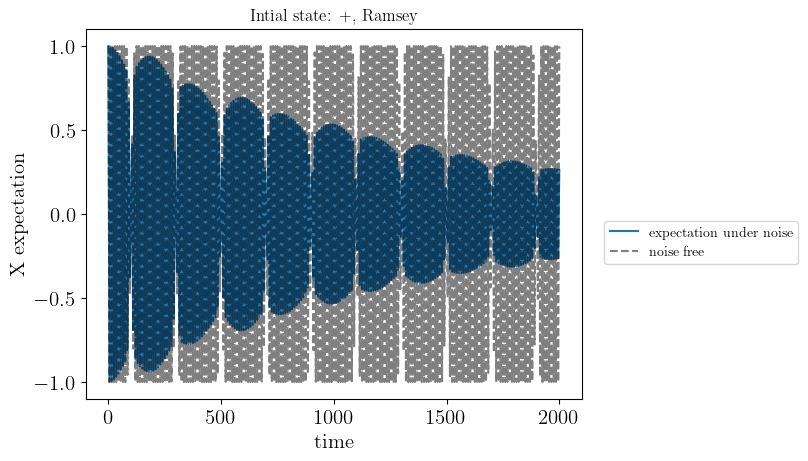

In [10]:
solver.e_ops = [sx]
pure_state = (q.basis(2,0) + q.basis(2,1))/np.sqrt(2)
solver.density0 = pure_state * pure_state.dag()
expect_list, expect_noise_free_list = solver.generate_expect()
plt.plot(solver.t_list_sub, expect_list[0].real, label = 'expectation under noise')
plt.plot(solver.t_list_sub, expect_noise_free_list[0].real, 'k--', label = 'noise free', alpha = 0.5)
plt.legend(bbox_to_anchor=(0.95, 0., 0.5, 0.5))
plt.xlabel('time')
plt.ylabel('X expectation')
plt.title('Intial state: +, Ramsey')

### Echo vs free induced

In [11]:
pure_state = (q.basis(2,0) + q.basis(2,1))/np.sqrt(2)
solver = kd.KeldyshSolver(H, t_list_output, minimal_step, noise_ops=[sz],
                            f_list=[f_list], Sf_list=[Sf_list], trunc_freq=[(-0.04, 0.04)], e_ops=[sx], 
                          density0 = pure_state * pure_state.dag(), spd_renorm_method = 'trapz', goal='expect')
solver2 = kd.KeldyshSolver(Hq, t_list_output, minimal_step, noise_ops=[sz],
                            f_list=[f_list], Sf_list=[Sf_list], trunc_freq=[(-0.04, 0.04)], e_ops=[sx], 
                          density0 = pure_state * pure_state.dag(), spd_renorm_method = 'trapz', goal='expect')

_, _ = solver.generate_errors(), solver2.generate_errors()

Text(0, 0.5, 'Process infidelity')

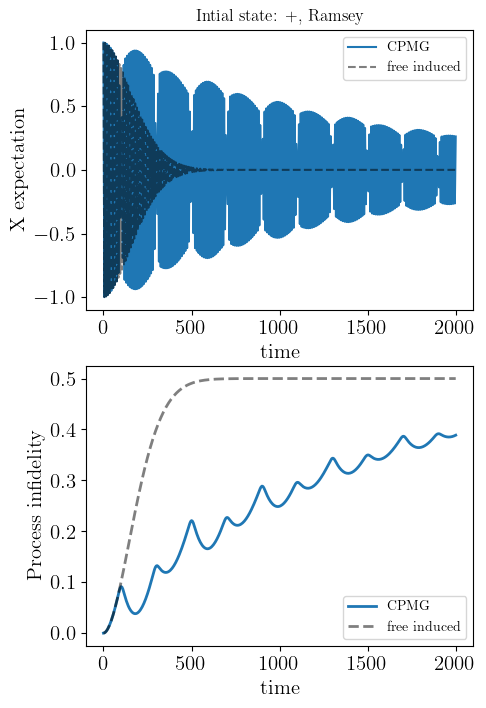

In [12]:
fig, ax = plt.subplots(2,1, figsize = (5,8))

ax[0].plot(solver.t_list_sub, solver.expect[0].real, label = 'CPMG')
ax[0].plot(solver2.t_list_sub, solver2.expect[0].real, 'k--', label = 'free induced', alpha = 0.5)
ax[0].legend()
ax[0].set_xlabel('time')
ax[0].set_ylabel('X expectation')
ax[0].set_title('Intial state: +, Ramsey')

ax[1].plot(solver.t_list_sub, solver.error_list, label = 'CPMG', lw = 2)
ax[1].plot(solver2.t_list_sub, solver2.error_list, 'k--', label = 'free induced', lw =2, alpha = 0.5)
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('Process infidelity')